# 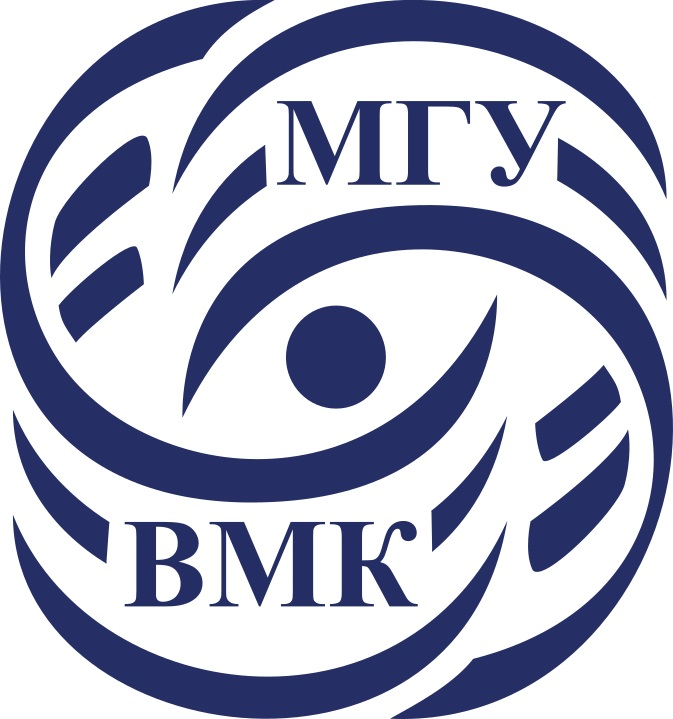

# Машинное обучение. ВМК МГУ

# Практическое задание 7: SVM
## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

Цель данного задания:

* Изучите работу модели SVM
* Поймете, как с её помощью можно строить нелинейные разделяющие поверхности
* Потренируетесь в подборе оптимальных параметров на обучающей выборке для достижения наилучшего качества на закрытой выборке (ML-решение)

-------
<font color="white" style="opacity:0.2024"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 10 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [ ]:
# !!! Данный блок будет работать только в Google-Colab !!!
! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
! pip install -r /content/requirements_2024_25_for_colab_small.txt

Проверим версию библиотеки:

In [ ]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2023"></font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

Приведем вспомогательный код

In [3]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [4]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()

def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(loc=1.0, size=(size1, 2)),
        np.random.normal(loc=0.5, size=(size2, 2))
    )]

    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [4]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1],
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

# Загрузка данных

In [5]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/1bp39_Jj0edo1lzxZ3DIoChsOVy5DVi1R?usp=sharing')

Retrieving folder contents


Retrieving folder 1tv605hGxdQtd4zC787DbcRF0312gDeK_ imbalanced
Processing file 14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u X_imb_test.npz.npy
Processing file 1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc X_imb.npz.npy
Processing file 1uD87Xbh4MMBBn5fsScrknI54SINIqory y_imb_test.npz.npy
Processing file 1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf y_imb.npz.npy
Retrieving folder 1uoI6vZWwIII1jd2k5TtsZTJ3JOkK0G6O public
Processing file 1Win7ZtHLHEbDtX6x6O7vBJHwJviQxbp5 cX_test.npy
Processing file 1MowPnLFAMEjjcAjDA4skE4OUFdmaiSY6 cX_train.npy
Processing file 1VYA4N5wCQhwteQSZkDogFTha2xRv0FgW cy_train.npy


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u
To: /media/midas/hardmachine/Files/msu/mlcmcmsu24/base/07_svm/05-SVM/imbalanced/X_imb_test.npz.npy
100%|██████████| 2.05k/2.05k [00:00<00:00, 5.81MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc
To: /media/midas/hardmachine/Files/msu/mlcmcmsu24/base/07_svm/05-SVM/imbalanced/X_imb.npz.npy
100%|██████████| 2.05k/2.05k [00:00<00:00, 4.92MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uD87Xbh4MMBBn5fsScrknI54SINIqory
To: /media/midas/hardmachine/Files/msu/mlcmcmsu24/base/07_svm/05-SVM/imbalanced/y_imb_test.npz.npy
100%|██████████| 1.09k/1.09k [00:00<00:00, 1.87MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf
To: /media/midas/hardmachine/Files/msu/mlcmcmsu24/base/07_svm/05-SVM/imbalanced/y_imb.npz.npy
100%|█

['/media/midas/hardmachine/Files/msu/mlcmcmsu24/base/07_svm/05-SVM/imbalanced/X_imb_test.npz.npy',
 '/media/midas/hardmachine/Files/msu/mlcmcmsu24/base/07_svm/05-SVM/imbalanced/X_imb.npz.npy',
 '/media/midas/hardmachine/Files/msu/mlcmcmsu24/base/07_svm/05-SVM/imbalanced/y_imb_test.npz.npy',
 '/media/midas/hardmachine/Files/msu/mlcmcmsu24/base/07_svm/05-SVM/imbalanced/y_imb.npz.npy',
 '/media/midas/hardmachine/Files/msu/mlcmcmsu24/base/07_svm/05-SVM/public/cX_test.npy',
 '/media/midas/hardmachine/Files/msu/mlcmcmsu24/base/07_svm/05-SVM/public/cX_train.npy',
 '/media/midas/hardmachine/Files/msu/mlcmcmsu24/base/07_svm/05-SVM/public/cy_train.npy']

# SVM и разделяющая поверхность

На лекции вы изучили, что линейная, с виду, модель SVM, при помощи некоторых "фокусов", называемых ядрами, умеет строить нелинейные поверхности. В данном ноутбуке посмотрим, как это все работает на практике, и какие гиперпараметры настройки у этого метода есть.

<font color='MediumTurquoise'>**Историческая справка:**</font> Метод опорных векторов (SVM) стал популярным в 90-х годах, особенно с 1995 года, благодаря своей эффективности в задачах классификации и способности обрабатывать высокоразмерные данные. Он также привлек внимание благодаря использованию ядровых функций, что позволяло решать нелинейные задачи. Однако с появлением более сложных методов, таких как глубокое обучение, и увеличением объема данных, SVM стал менее популярным, поскольку более современные алгоритмы демонстрировали лучшие результаты на больших наборах данных и обеспечивали более простую настройку.

## <font color='DarkOrange'>**Задание 1 [1 балл]**</font>


В ячейке ниже генерируется выборка, состоящая из объектов двух классов. Каждый объект представлен двумя координатами, так что объекты этой выборки можно отобразить на плоскости, используя функцию scatter из библиотеки matplotlib.


    
В этом задании вам надо будет обучить линейную разделяющую поверхность с помощью $\mbox{sklearn.svm.SVC(kernel='linear')}$, а также нелинейную c rbf-ядром с помощью $\mbox{sklearn.svm.SVC(kernel='rbf')}$. Остальные параметры методов можете оставить дефолтными. Делить выборку на обучение и валидацию сейчас не требуется, так как нас будет пока интересовать только форма разделяющей кривой.

In [6]:
X, y = make_moons_cls()
linear_svc = SVC(kernel='linear')
nonlinear_svc = SVC(kernel='rbf')

Визуализируем выборку

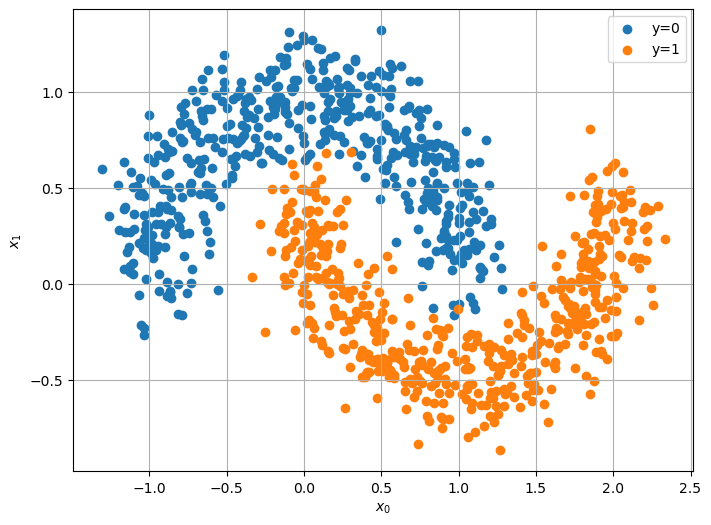

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.grid()

Обучите модели и визуализируйте разделяющую поверхность для обеих моделей с помощью функции plot_separating_surface(). Посчитайте точность (accuracy) на обучающей выборке для каждой из моделей.

In [9]:
linear_svc.fit(X, y)
print(f'Train Accuracy (linear): {accuracy_score(y, linear_svc.predict(X)):.3f}')

Train Accuracy (linear): 0.861


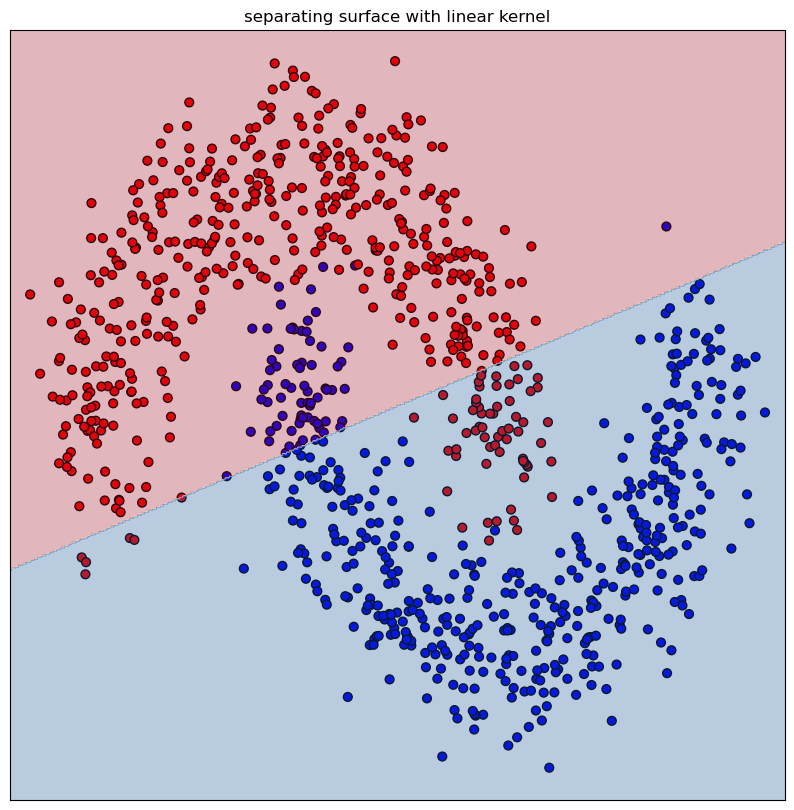

In [13]:
plot_separating_surface(X, y, linear_svc, False, 'separating surface with linear kernel')

In [10]:
nonlinear_svc.fit(X, y)
print(f'Train Accuracy (non linear): {accuracy_score(y, nonlinear_svc.predict(X)):.3f}')

Train Accuracy (non linear): 0.989


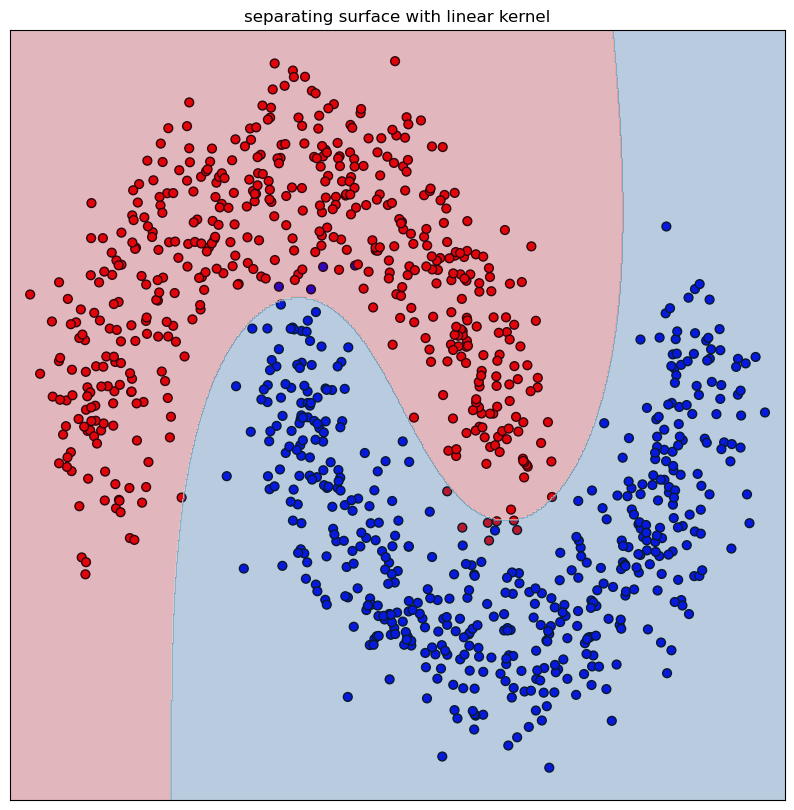

In [14]:
plot_separating_surface(X, y, nonlinear_svc, False, 'separating surface with linear kernel')

**Сделайте вывод**
о получившихся результатах. Какая из моделей лучше подходит для данной выборки и почему?

<font color='MediumOrchid'>Вывод:</font> поскольку поверхность, разделяющая классы, нелинейна, то модель с rbf-ядром, с помощью которого можно моделировать нелинейные зависимости, очевидно, является здесь фаворитом. Точность при использовании rbf-ядра значительно больше, поскольку разделяющая поверхность в случае линейного ядра отсекает много объектов, принадлежащих противоположному классу.

## 2. Опорные объекты

Продолжаем работать с выборкой и моделями из первой части. Для линейной и rbf-моделей рассмотрим
    опорные объекты, полученные после обучения. Визуализировать их можно, используя функуцию plot_separating_surface с параметром vis_support=True. Достанем опорные объекты из обученной модели с помощью поля model.support_.

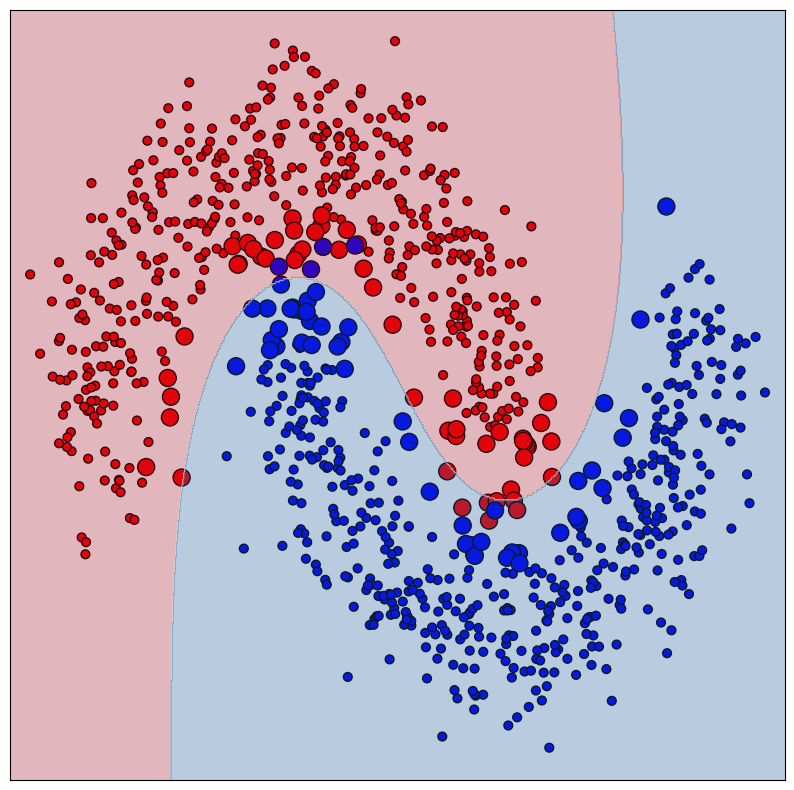

In [15]:
plot_separating_surface(X, y, nonlinear_svc, view_support=True)

Обучим новые две модели $\mbox{SVC(kernel='rbf')}$, используя только опорные объекты построенные с помощью соответственно линейной (linear_svc) и нелинейной (nonlinear_svc) моделей из первой части.

In [16]:
# Учим модели только на опорных объектах
svc_on_linear_support = SVC(kernel='rbf').fit(X[linear_svc.support_, :], y[linear_svc.support_])
svc_on_rbf_support = SVC(kernel='rbf').fit(X[nonlinear_svc.support_, :], y[nonlinear_svc.support_])

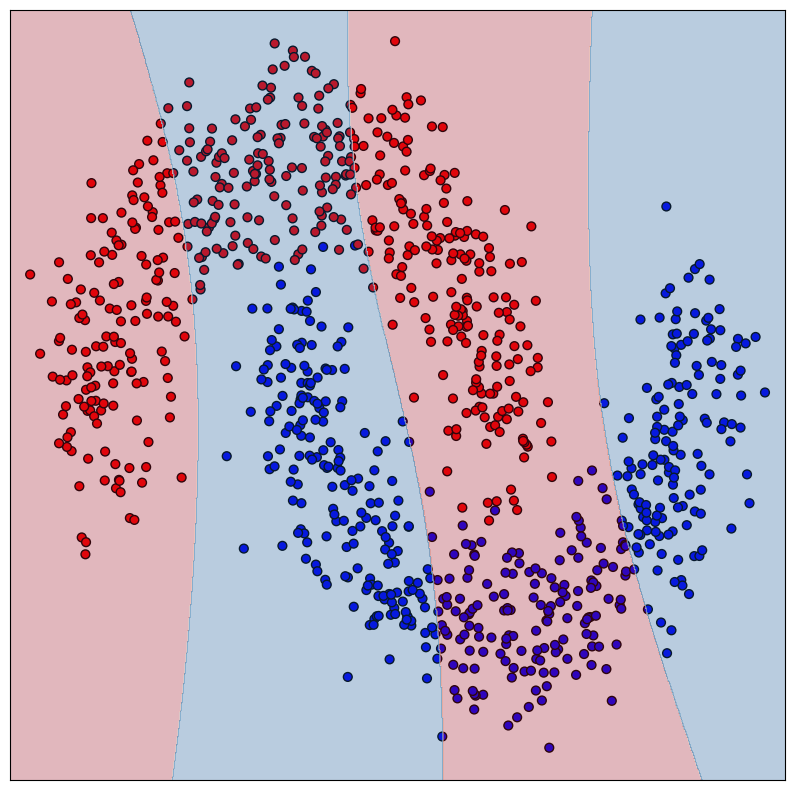

In [17]:
plot_separating_surface(X, y, svc_on_linear_support)

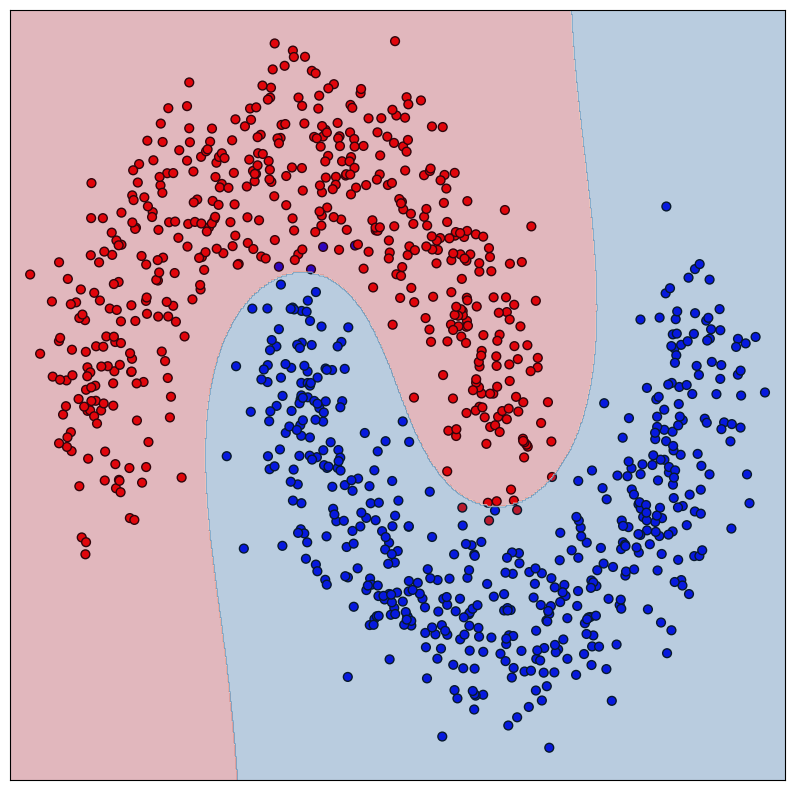

In [18]:
plot_separating_surface(X, y, svc_on_rbf_support)

### <font color='DarkOrange'>**Задание 2 [1 балл]**</font>

Сравните полученные разделяющие поверхности с нелинейной моделью (nonlinear_svc) из задания 1. Какая из поверхностей больше похожа на нелинейнную модель из первой части и почему, опишите в выводе.


<font color='MediumOrchid'>**Вывод:**</font> поскольку в методе опорных векторов решение зависит только от, собственно, опорных векторов, то при обучении модели с rbf-ядром только на опорных векторах, полученных ранее от модели с rbf-ядром, разделяющая поверхность практически не изменится (что визуально продемонстрировано выше). Однако если обучить модель с rbf-ядром на опорных векторах от модели с линейным ядром, то разделяющая поверхность будет построена некорректно, поскольку наборы опорных векторов там и там разные.

---

Теперь обучим модель $\mbox{SVC(kernel='rbf')}$, используя все объекты кроме тех, что являлись опорными для нелинейной модели из первой части (nonlinear_svc) и сравним эту модель вместе с svc_on_rbf_support с нелинейной моделью из задания 1(nonlinear_svc). Визуализируйте разделяющие поверхности обеих моделей.

In [19]:
non_support_vectors = [i for i in range(len(X)) if i not in nonlinear_svc.support_]
svc_all_without_rbf_support = SVC(kernel='rbf').fit(X[non_support_vectors, :], y[non_support_vectors])

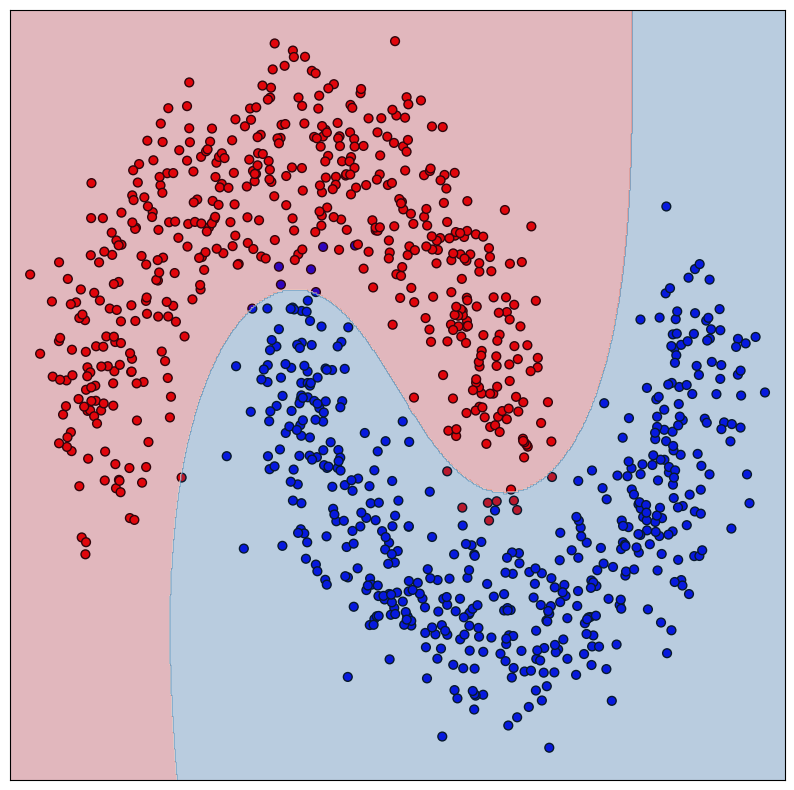

In [20]:
plot_separating_surface(X, y, svc_all_without_rbf_support)

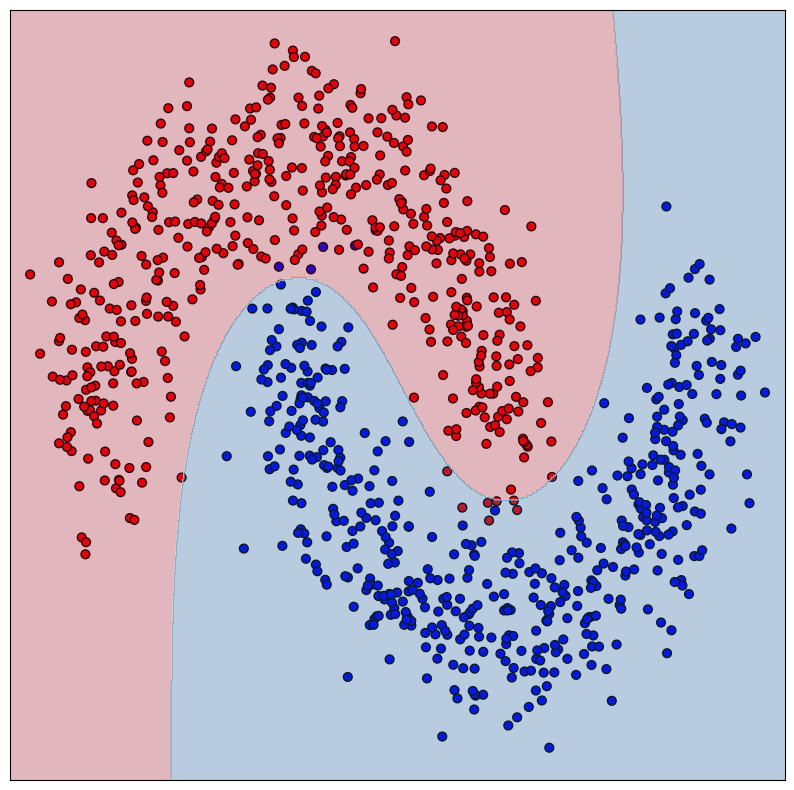

In [21]:
plot_separating_surface(X, y, nonlinear_svc)

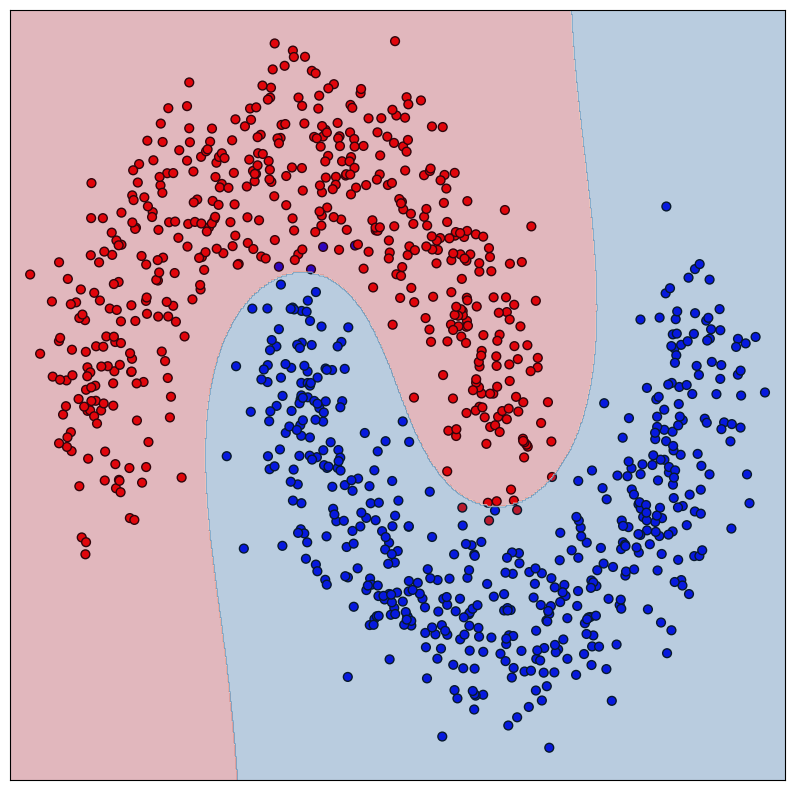

In [22]:
plot_separating_surface(X, y, svc_on_rbf_support)

### <font color='DarkOrange'>**Задание 3 [1.5 баллa]**</font>

**Сделайте вывод:** Сильно ли полученные поверхности отличаются от той, что была получена в первом задании? Что произошло с пограничными объектами? Объясните полученные результаты.

<font color='MediumOrchid'>**Вывод:**</font> нет, все три поверхности практически не различаются. Модель, обученная без опорных векторов, полученных ранее, определила новые опорные векторы, и разделяющая поверхность получилась такая же (поскольку как старые, так и новые векторы располагаются около границ разделов классов).

# 4. Обучите лучшую SVM модель (ML-решение)

Возможность строить нелинейные поверхности может сильно улучшить качество, но и несет риск переобучения.
    В этом задании предстоит обучить лучшую svm модель и получить хорошее качество на тесте в системе тестирования. Для контроля переобучения рекомендуется пользоваться кросс-валидацией. Для улучшения качества рекомендуется подбирать

1. параметр регуляризации C;
2. тип разделяющей кривой linear/rbf/poly;
3. степень в случае разделяющей кривой poly.

Также не забывайте, что при решении задач машинного обучения полезно смотреть в данные :)

Все csv-таблицы с данными вы можете взять из публичного теста, который также есть в проверяющей системе. Для этого распакуйте архив с публичными тестами и положите файлы в рабочей директории (рядом с ноутбуком)

In [5]:
X_train = np.load('05-SVM/public/cX_train.npy')
y_train = np.load('05-SVM/public/cy_train.npy')
X_test = np.load('05-SVM/public/cX_test.npy')

In [6]:
X_train.shape, y_train.shape, X_test.shape

((800, 5), (800,), (200, 5))

In [8]:
X = X_train
y = y_train.ravel()

In [9]:
df = pd.DataFrame(X_train)
s = pd.Series(y)
df.head(), s.head()

(          0         1         2         3         4
 0  0.116719 -0.284032 -0.782849 -0.334250  0.730586
 1  2.402175 -0.854173 -0.529339  0.904358 -0.022276
 2 -0.727087  0.308225  1.065419 -0.546791 -0.949516
 3 -0.776475  0.676887  0.813676 -0.970964 -0.238214
 4 -0.348739  0.113919 -1.766417 -0.519399 -2.016236,
 0    1.0
 1    1.0
 2    0.0
 3    1.0
 4    0.0
 dtype: float64)

In [10]:
df.corrwith(s, axis=0)

0    0.045753
1   -0.038594
2    0.027435
3    0.029656
4    0.281980
dtype: float64

In [11]:
s.value_counts()

1.0    482
0.0    318
Name: count, dtype: int64

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [60]:
parameters = {
    'clf__C': np.logspace(-6, 4, 50),
}

pipeline = Pipeline([
    ['scaler', StandardScaler()],
    ['clf', SVC(kernel='rbf', class_weight={0: 1.2, 1: 1})]
])

X_new = df.loc[:, [0, 3, 4]].to_numpy()
y_new = s.to_numpy()

src = GridSearchCV(pipeline, parameters, scoring='f1', n_jobs=-1, cv=3, verbose=10)
src.fit(X_new, y_new)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[CV 2/3; 1/50] START clf__C=1e-06...............................................
[CV 2/3; 1/50] END ................clf__C=1e-06;, score=0.752 total time=   0.0s
[CV 1/3; 5/50] START clf__C=6.5512855685955095e-06..............................
[CV 1/3; 5/50] END clf__C=6.5512855685955095e-06;, score=0.752 total time=   0.0s
[CV 2/3; 5/50] START clf__C=6.5512855685955095e-06..............................
[CV 2/3; 5/50] END clf__C=6.5512855685955095e-06;, score=0.752 total time=   0.0s
[CV 3/3; 5/50] START clf__C=6.5512855685955095e-06..............................
[CV 1/3; 2/50] START clf__C=1.5998587196060574e-06..............................
[CV 1/3; 1/50] START clf__C=1e-06...............................................
[CV 1/3; 2/50] END clf__C=1.5998587196060574e-06;, score=0.752 total time=   0.0s
[CV 3/3; 5/50] END clf__C=6.5512855685955095e-06;, score=0.751 total time=   0.1s[CV 1/3; 1/50] END ................clf__C=1e-06;, score=0.752 total time=   0.0s

[CV 1/3; 6/50] START clf

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[['scaler', StandardScaler()],
                                       ['clf',
                                        SVC(class_weight={0: 1.2, 1: 1})]]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.00000000e-06, 1.59985872e-06, 2.55954792e-06, 4.09491506e-06,
       6.55128557e-06, 1.04811313e-05, 1.67683294e-05, 2.68269580e-05,
       4.29193426e-05, 6.86648845e-05, 1.09854114e-04, 1.75751062e-04,
       2.81176870e-04, 4.498...
       5.17947468e-01, 8.28642773e-01, 1.32571137e+00, 2.12095089e+00,
       3.39322177e+00, 5.42867544e+00, 8.68511374e+00, 1.38949549e+01,
       2.22299648e+01, 3.55648031e+01, 5.68986603e+01, 9.10298178e+01,
       1.45634848e+02, 2.32995181e+02, 3.72759372e+02, 5.96362332e+02,
       9.54095476e+02, 1.52641797e+03, 2.44205309e+03, 3.90693994e+03,
       6.25055193e+03, 1.00000000e+04])},
             scoring='f1', verbose=10)

In [61]:
src.best_score_

np.float64(0.9535630957527372)

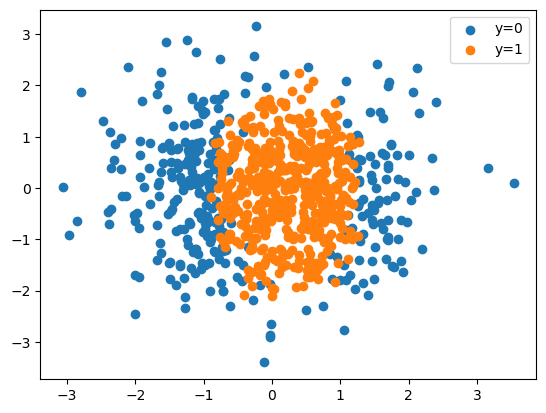

In [26]:
plt.scatter(X[y == 0, 4], X[y == 0, 3], label='y=0')
plt.scatter(X[y == 1, 4], X[y == 1, 3], label='y=1')
plt.legend()

**Отправьте код обучения модели с оптимальными параметрами в проверяющую систему, воспользовавшись приложенным шаблоном svm_solution.py. Кросс-валидацию параметров в посылаемом решении делать <font color='red'>не нужно</font> -- достаточно подобрать, например, их тут, а в решении уже обучать модель с оптимальными параметрами.**

# Сравнение с логистической регрессией

#### <font color='DarkOrange'>**Задание 4 [1.5 баллa]**</font>

В предыдущей части Вы обучили хорошую SVM модель, подбирая гиперпараметры модели. Давайте теперь попробуем обучить логистическую регрессию на этой же выборке, и по кросс-валидации оценить влияние гиперпараметров на линейную модель.

In [135]:
from sklearn.linear_model import LogisticRegression

In [140]:
parameters = {
    'clf__C': np.logspace(-6, 4, 50),
}

pipeline = Pipeline([
    ['scaler', StandardScaler()],
    ['clf', LogisticRegression()]
])

X_new = df.loc[:, [0, 3, 4]].to_numpy()
y_new = s.to_numpy()

src = GridSearchCV(pipeline, parameters, scoring='f1', n_jobs=-1, cv=3, verbose=10)
src.fit(X_new, y_new)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START clf__C=1e-06...............................................
[CV 2/3; 1/50] START clf__C=1e-06...............................................
[CV 3/3; 1/50] START clf__C=1e-06...............................................
[CV 1/3; 2/50] START clf__C=1.5998587196060574e-06..............................
[CV 2/3; 2/50] START clf__C=1.5998587196060574e-06..............................
[CV 3/3; 2/50] START clf__C=1.5998587196060574e-06..............................
[CV 1/3; 3/50] START clf__C=2.5595479226995334e-06..............................
[CV 2/3; 3/50] START clf__C=2.5595479226995334e-06..............................
[CV 3/3; 3/50] START clf__C=2.5595479226995334e-06..............................
[CV 1/3; 2/50] END clf__C=1.5998587196060574e-06;, score=0.752 total time=   0.0s
[CV 1/3; 4/50] START clf__C=4.094915062380427e-06...............................
[CV 1/3; 1/50] END ................clf__C=1e-0

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[['scaler', StandardScaler()],
                                       ['clf', LogisticRegression()]]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.00000000e-06, 1.59985872e-06, 2.55954792e-06, 4.09491506e-06,
       6.55128557e-06, 1.04811313e-05, 1.67683294e-05, 2.68269580e-05,
       4.29193426e-05, 6.86648845e-05, 1.09854114e-04, 1.75751062e-04,
       2.81176870e-04, 4.49843267e-04...
       5.17947468e-01, 8.28642773e-01, 1.32571137e+00, 2.12095089e+00,
       3.39322177e+00, 5.42867544e+00, 8.68511374e+00, 1.38949549e+01,
       2.22299648e+01, 3.55648031e+01, 5.68986603e+01, 9.10298178e+01,
       1.45634848e+02, 2.32995181e+02, 3.72759372e+02, 5.96362332e+02,
       9.54095476e+02, 1.52641797e+03, 2.44205309e+03, 3.90693994e+03,
       6.25055193e+03, 1.00000000e+04])},
             scoring='f1', verbose=10)

In [141]:
src.best_score_

np.float64(0.8557923996462439)

Сделайте выводы о влиянии выбора гиперпараметров на качество обучения линейной и SVC моделей. Также опишите, какие преобразования выборки/подбор каких гиперпараметров помогли добиться высокого качества на кросс-валидации в данной задаче.

<font color='MediumOrchid'>Вывод:</font> можно заметить, что правильный выбор гиперпараметра $C$ по сетке значений сильно влияет на итоговое качество как логрегрессии, так и SVC. При некоторых $C$ значения метрики качества (F1-score) на кросс-валидации падали до 0.75, в то время как лучший результат на кросс-валидации для логрегрессии - 0.856, а для SVC с rbf-ядром - 0.953.  
Наилучшее качество было получено при помощи правильного подбора $C$ по сетке, а также грамотный отбор признаков (так, были выброшены 2 и 3 признаки, ибо лишь зашумляли данные, а не корректировали их) и балансирование весов классов.

### <font color='MediumSeaGreen'>**Задание 5 [1 балл][Bonus]**</font>

Найдите мем про SVM лучше чем этот:

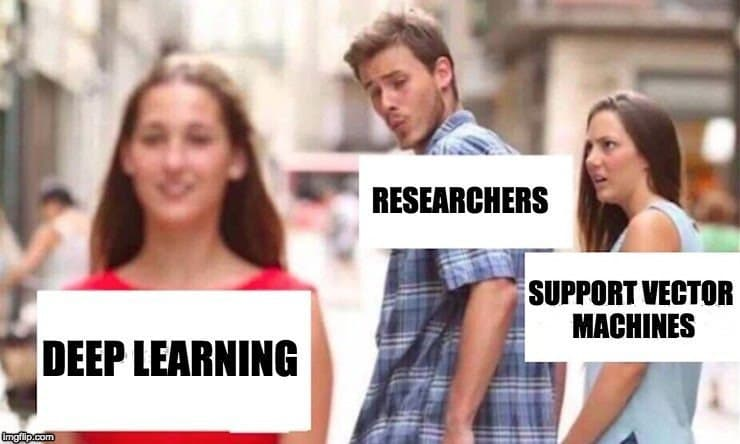

Важно: самый простой способ вставить картинку будет через Google Colab (даже если вы изначально делали не в нем). Нажмите на **"+ Text"**, в появившейся ячейке сделайте **прикрепление картинки** (как на скринах). Тогда ваша картинка "зашифруется" и будет корректно отображаться при конвертации в html

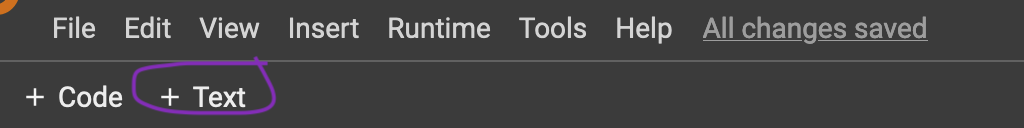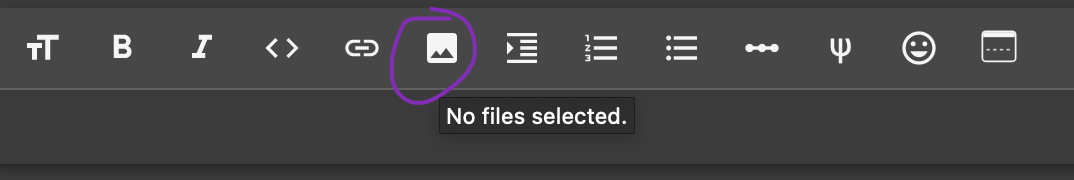

![](https://editor.analyticsvidhya.com/uploads/30927SVM%201.png)